# **Term Deposit Marketing**

##### Prepared by: Japhet Hernández-Vaquero
##### Apziva 2024

## **Summary**

  This bi-class classification project involves 3 different facets:
  1. A two-layer machine learning prediction system with two purposes:

     a. The first layer aims to maximize the number of true class-1 customers that are correctly identified, as a strategy to recognize potential customers.
     b. The second layer seeks to increase the precision of the prediction of both classes, in an attempt to foster the identification of those class-1 customers on which the call center agents must persist on reaching them, since they are more likely to subscribe to the service.
  2. A SHAP analysis to identify the most important attributes that impact on the prediction of subscribers, and whether their effect is positive or negative on the prediction.
  3. A clustering approach to segment the customers that didd subscribed to the term deposit.

  * An accuracy of 0.867 was achieved by the two-layer ML system, leaving only 105 true subscribers out of 2196 out of radar.
  * The most important features with a negative impact on prediction are:
    * *Duration* shorter than 261 sec relates to a customer not very unlikely to subscribe.
    * Having a *Housing* loan.
  * The features with the greatest, positive impact, are:
    * *Prediction from Layer 1*
    * *Duration* with very high values.
  *



## **Background**

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.


### **Data Description**


The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

### **Attributes**

* age : age of customer (numeric)

* job : type of job (categorical)

* marital : marital status (categorical)

* education (categorical)

* default: has credit in default? (binary)

* balance: average yearly balance, in euros (numeric)

* housing: has a housing loan? (binary)

* loan: has personal loan? (binary)

* contact: contact communication type (categorical)

* day: last contact day of the month (numeric)

* month: last contact month of year (categorical)

* duration: last contact duration, in seconds (numeric)

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

**Output (desired target):**

* y - has the client subscribed to a term deposit? (binary)

### **Goal:**

* Predict if the customer will subscribe (yes/no) to a term deposit (variable y)


### **Success Metric(s)**

* Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.


### **Bonus(es)**

* We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

* What makes the customers buy? Tell us which feature we should be focusing more on.

## **0. Installing and importing libraries**


In [4]:
!pip -q install orjson==3.9.5 --only-binary :all:
!pip -q install optuna
!pip -q install --pre pycaret
!pip -q install pycaret # Installing PyCaret (last stable version)
!pip -q install ydata-profiling # Install ydata-profiling (equivalent to pandas profiling)
!pip -q install sweetviz # Install sweetviz
!pip -q install prince # Install prince
!pip -q install tpot
!pip -q install shap
!pip -q install umap-learn

In [ ]:
!pip -quninstall pycaret -y
!pip -q install pycaret

### **Importing libraries**

In [6]:
import pandas as pd # For manipulating data
import numpy as np # For operations
import matplotlib.pyplot as plt # For visualization
import seaborn as sns # For visualization
import pycaret # Library for low-code ML training
from pycaret.classification import * # Classification library
from pycaret.classification import ClassificationExperiment, setup, plot_model, stack_models, blend_models, create_model # Import ClassificationExperiment
from pycaret.clustering import * # Clustering library
from pycaret.clustering import ClusteringExperiment, setup # Import ClusteringExperiment

from sklearn.model_selection import train_test_split # Split in train and test set
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif, f_regression, mutual_info_classif, mutual_info_regression # Feature selection
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree

import time

from ydata_profiling import ProfileReport # Low-code EDA
import sweetviz as sv
import prince # Library for Multiple Correspondence Analysis
from prince import MCA
from scipy.stats import chi2_contingency # Chi-Square Test for Hypothesis testing

from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

import torch
import optuna

from tpot import TPOTClassifier

import shap
from sklearn.metrics import mean_squared_error

import joblib
from joblib import load

## ***************************** RandomUnderSampler****************************
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from collections import Counter
## ****************************************************************************

## ***************************** SMOTE ****************************************
from imblearn.over_sampling import SMOTE
## ****************************************************************************

## ***************************** SMOTE ENN ************************************
from imblearn.combine import SMOTEENN
## ****************************************************************************

## ***************************** SMOTE TOMEK **********************************
from imblearn.combine import SMOTETomek
## ****************************************************************************

from sklearn.manifold import TSNE

from umap import UMAP

import warnings # To ignore warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_column', None) # To display all columns
pd.set_option('display.max_rows', None) # To display all rows.


In [7]:
df = pd.read_csv('term-deposit-marketing-2020 - term-deposit-marketing-2020.csv') # Import data

### **Seed**

In [8]:
## **Seed**
import random
seed = random.randint(1000, 9999)
#print(seed)
seed = 5714

### **First look at the data**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


## **I. Exploratory Data Analysis**

In [11]:
# We create lists of categorical and numerical features.
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']
num_vars = ['age', 'balance', 'day', 'duration', 'campaign']
first_layer_vars = ['age', 'balance', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']
second_layer_vars = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing','loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y']

In [12]:
profile = ProfileReport(df[first_layer_vars], title = 'Pandas Profiling Report') # Profile of whole dataset
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Observations:**

* 61% of the customers is married.
* The most popular jobs of the customers are *blue-collar* (23.5%) and *management* (20.4%).
* 52.5% has secondary education, while 28% has terciary education.


In [13]:
report = sv.analyze(df)
report.show_html('report_sweetviz.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [14]:
profile_subscribers = ProfileReport(df[df['y'] == 'yes'][second_layer_vars], title = 'Pandas Subscribers Profiling Report') # Profile of subscribers
profile_subscribers

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
df_subscribers = df[df['y'] == 'yes']
correspondence = MCA(n_components = 2, n_iter = 3, random_state = seed)  # MCA analysis
correspondence.fit(df_subscribers[cat_vars])

MCA(n_iter=3, random_state=5714)

In [16]:
correspondence.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.229         8.74%                      8.74%
1              0.185         7.03%                     15.77%

In [17]:
row_coord = correspondence.row_coordinates(df_subscribers[cat_vars])
row_coord['Source'] = 'Row'

In [18]:
col_coord = correspondence.column_coordinates(df_subscribers[cat_vars])
col_coord['Source'] = 'Column'

In [19]:
correspondence.plot(df_subscribers[cat_vars], x_component = 0, y_component = 1, show_column_markers = True, show_row_markers = False, show_column_labels = True, show_row_labels = False)

alt.LayerChart(...)

**Observations:**

* As identified in the EDA, the correspondence analysis confirms that there is a strong association between **not being at default** and **positive subscriber**. Similarly, **having no loans** is also very associated to **positive subscriber**.

* **Having a good payment behavior** is the most distinguishable feature of a customer who subscribes to the investment.This includes those customers that have **never had a loan**.

## **II. First Layer of ML model**

### **Splitting the dataset**

#### **Mapping**

In [20]:
y_map = { 'no' : 0, 'yes' : 1}
job_map = {
    'management': 0,
    'technician': 1,
    'entrepreneur': 2,
    'blue-collar': 3,
    'unknown': 4,
    'retired': 5,
    'admin': 6,
    'services': 7,
    'self-employed': 8,
    'unemployed': 9,
    'housemaid': 10,
    'student': 11
}
marital_map = {
    'married': 1,
    'single': 0,
    'divorced': 2
}

education_map = {
    'secondary': 3,
    'tertiary': 2,
    'primary': 1,
    'unknown': 0
}
default_map = {
    'no': 0,
    'yes': 1
}
housing_map = {
    'no': 0,
    'yes': 1
}
loan_map = {
    'no': 0,
    'yes': 1
}
contact_map = {
    'unknown': 0,
    'cellular': 1,
    'telephone': 2
}
df_first = df.copy()#df[first_layer_vars].copy()
#df_first = pd.get_dummies(df_first, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact'])
df_first['y'] = df_first['y'].map(y_map)
df_first['job'] = df_first['job'].map(job_map)
df_first['marital'] = df_first['marital'].map(marital_map)
df_first['education'] = df_first['education'].map(education_map)
df_first['default'] = df_first['default'].map(default_map)
df_first['housing'] = df_first['housing'].map(housing_map)
df_first['loan'] = df_first['loan'].map(loan_map)
df_first['contact'] = df_first['contact'].map(contact_map)

df_first.describe().T

count         mean          std     min    25%    50%     75%  \
age        40000.0    40.544600     9.641776    19.0   33.0   39.0    48.0   
job        40000.0     3.452150     3.020437     0.0    1.0    3.0     6.0   
marital    40000.0     0.845900     0.605485     0.0    0.0    1.0     1.0   
education  40000.0     2.291525     0.865856     0.0    2.0    3.0     3.0   
default    40000.0     0.020225     0.140771     0.0    0.0    0.0     0.0   
balance    40000.0  1274.277550  2903.769716 -8019.0   54.0  407.0  1319.0   
housing    40000.0     0.600775     0.489745     0.0    0.0    1.0     1.0   
loan       40000.0     0.173250     0.378468     0.0    0.0    0.0     0.0   
contact    40000.0     0.738900     0.555864     0.0    0.0    1.0     1.0   
day        40000.0    16.017225     8.278127     1.0    8.0   17.0    21.0   
duration   40000.0   254.824300   259.366498     0.0  100.0  175.0   313.0   
campaign   40000.0     2.882175     3.239051     1.0    1.0    2.0     3.0   
y          40000.0     0.072400     0.259152     0.0    0.0    0.0     0.0   

                max  
age            95.0  
job            11.0  
marital         2.0  
education       3.0  
default         1.0  
balance    102127.0  
housing         1.0  
loan            1.0  
contact         2.0  
day            31.0  
duration     4918.0  
campaign       63.0  
y               1.0

In [21]:
df_first.head()

age  job  marital  education  default  balance  housing  loan  contact  \
0   58    0        1          2        0     2143        1     0        0   
1   44    1        0          3        0       29        1     0        0   
2   33    2        1          3        0        2        1     1        0   
3   47    3        1          0        0     1506        1     0        0   
4   33    4        0          0        0        1        0     0        0   

   day month  duration  campaign  y  
0    5   may       261         1  0  
1    5   may       151         1  0  
2    5   may        76         1  0  
3    5   may        92         1  0  
4    5   may       198         1  0

In [22]:
df_first.head()

age  job  marital  education  default  balance  housing  loan  contact  \
0   58    0        1          2        0     2143        1     0        0   
1   44    1        0          3        0       29        1     0        0   
2   33    2        1          3        0        2        1     1        0   
3   47    3        1          0        0     1506        1     0        0   
4   33    4        0          0        0        1        0     0        0   

   day month  duration  campaign  y  
0    5   may       261         1  0  
1    5   may       151         1  0  
2    5   may        76         1  0  
3    5   may        92         1  0  
4    5   may       198         1  0

In [23]:
df_first.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

### **First iteration for ML model**

In [24]:
from pycaret.classification import *
exp = setup(data = df_first[first_layer_vars], target = 'y', train_size = 0.7, fix_imbalance = True, fold = 5, session_id = seed, normalize = True, index = True) #feature_selection = True, feature_selection_method = 'classic', n_features_to_select = 4) # Init Setup on the experiment

In [25]:
x_train, x_test, y_train, y_test = get_config('X_train'), get_config('X_test'), get_config('y_train'), get_config('y_test')

In [ ]:
exp.compare_models(exclude = ['lightgbm', 'qda'], sort = 'Recall')

Processing:   0%|          | 0/57 [00:00<?, ?it/s]

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

**Observations:**

* We would like to have a set of potential subscribing customers. Then we will consider **recall of class 1** as our comparison metric.
* The top 3 classifiers on this basis are:
  * Dummy Classifier
  * Gradient Boosting Classifier
  * Ada Boost Classifier
  * Light Gradient Boosting Machine

In [ ]:
# Generate leaderboard
exp.get_leaderboard()

Processing:   0%|          | 0/14 [00:00<?, ?it/s]

Model Name  \
Index                                 
0               Logistic Regression   
1            K Neighbors Classifier   
2                       Naive Bayes   
3          Decision Tree Classifier   
4               SVM - Linear Kernel   
5                  Ridge Classifier   
6          Random Forest Classifier   
7              Ada Boost Classifier   
8      Gradient Boosting Classifier   
9      Linear Discriminant Analysis   
10           Extra Trees Classifier   
11        Extreme Gradient Boosting   
12                 Dummy Classifier   

                                                   Model  Accuracy     AUC  \
Index                                                                        
0      (TransformerWrapper(exclude=None,\n           ...    0.5520  0.6123   
1      (TransformerWrapper(exclude=None,\n           ...    0.8449  0.5508   
2      (TransformerWrapper(exclude=None,\n           ...    0.5335  0.6002   
3      (TransformerWrapper(exclude=None,\n           ...    0.8622  0.5291   
4      (TransformerWrapper(exclude=None,\n           ...    0.4662  0.6039   
5      (TransformerWrapper(exclude=None,\n           ...    0.5512  0.6122   
6      (TransformerWrapper(exclude=None,\n           ...    0.9148  0.5766   
7      (TransformerWrapper(exclude=None,\n           ...    0.9233  0.6252   
8      (TransformerWrapper(exclude=None,\n           ...    0.9262  0.6375   
9      (TransformerWrapper(exclude=None,\n           ...    0.5512  0.6122   
10     (TransformerWrapper(exclude=None,\n           ...    0.8981  0.5643   
11     (TransformerWrapper(exclude=None,\n           ...    0.9254  0.6147   
12     (TransformerWrapper(exclude=None,\n           ...    0.9276  0.5000   

       Recall   Prec.      F1   Kappa     MCC  
Index                                          
0      0.6211  0.0966  0.1672  0.0479  0.0872  
1      0.1628  0.1109  0.1319  0.0501  0.0512  
2      0.6399  0.0952  0.1658  0.0455  0.0856  
3      0.1366  0.1159  0.1254  0.0512  0.0514  
4      0.6986  0.0900  0.1593  0.0357  0.0772  
5      0.6216  0.0965  0.1670  0.0477  0.0869  
6      0.0582  0.1994  0.0900  0.0591  0.0718  
7      0.0158  0.1982  0.0282  0.0168  0.0334  
8      0.0084  0.2397  0.0162  0.0112  0.0320  
9      0.6216  0.0965  0.1670  0.0477  0.0869  
10     0.0873  0.1511  0.1106  0.0606  0.0632  
11     0.0247  0.3087  0.0457  0.0354  0.0696  
12     0.0000  0.0000  0.0000  0.0000  0.0000

In [ ]:
df.head()

age  job  marital  education  default  balance  housing  loan  contact  \
0   58    0        0          2        0     2143        1     0        0   
1   44    1        1          3        0       29        1     0        0   
2   33    2        0          3        0        2        1     1        0   
3   47    3        0          0        0     1506        1     0        0   
4   33    4        1          0        0        1        0     0        0   

   day month  duration  campaign  y  
0    5   may       261         1  0  
1    5   may       151         1  0  
2    5   may        76         1  0  
3    5   may        92         1  0  
4    5   may       198         1  0

##### **SVM Classifier**

In [26]:
svm_model = exp.create_model('svm', fold = 5, cross_validation = True, probability_threshold = 0.5, verbose = True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
evaluate_model(svm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
import pickle
#save_model(svm_model, 'svm_model')
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

##### **Hyperparameter Optimization**



In [34]:
def objective_dt(trial):
  param_grid = {
        #'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter': trial
        .suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 1, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),

    }
  model = DecisionTreeClassifier(**param_grid, random_state=seed)

  pipeline = Pipeline([('scaler', StandardScaler()), ('dt', model)])

  cv  = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
  score = cross_val_score(pipeline, x_train, y_train, cv = cv, scoring = 'recall')
  mean_score = score.mean()
  return mean_score

In [36]:
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler())
study.optimize(objective_dt, n_trials = 100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
  print(f"  {key}: {value}")

[I 2024-09-03 06:42:01,595] A new study created in memory with name: no-name-33ecb67f-db10-4f75-b82d-d88cc6a5bfd3
[I 2024-09-03 06:42:01,715] Trial 0 finished with value: 0.6 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.4604401828005837, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6.
[I 2024-09-03 06:42:01,808] Trial 1 finished with value: 0.6 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.45949644085892455, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6.
[I 2024-09-03 06:42:01,897] Trial 2 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 11, 'min_samples_leaf': 11, 'min_impurity_decrease': 0.2590860843605681, 'class_weight': None}. Best is trial 0 with value: 0.6.
[I 2024

Number of finished trials:  100
Best trial:
 Value:  0.8273307790549171
 Params: 
  criterion: gini
  splitter: best
  max_depth: 18
  min_samples_split: 17
  min_samples_leaf: 15
  min_impurity_decrease: 0.008681952231593904
  class_weight: balanced


##### **Pre-second layer**

In [62]:
# Confusion Matrix Function
def confusion_matrix_heatmap(actual, predicted):
  plt.figure(figsize = (3, 2))
  cm = confusion_matrix(actual, predicted)
  sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
  plt.xticks([0.5, 1.5], ['Not Subscribed', 'Subscribed'])
  plt.yticks([0.5, 1.5], ['Not Subscribed', 'Subscribed'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [30]:
tuned_dt_model = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 14, min_samples_split = 5, min_samples_leaf = 18, min_impurity_decrease = 0.007682163338046909, class_weight = 'balanced')
tuned_dt_model.fit(x_train, y_train)
y_pred_train = tuned_dt_model.predict(x_train)
cv  = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

score_dt_train = cross_val_score(tuned_dt_model, x_train, y_train, cv = cv, scoring = 'recall')
score_dt_train.mean()



0.8273295627318615

In [31]:
x_test_total_dataset = df_first[first_layer_vars].copy()
x_test_total_dataset.drop(columns = ['y'], inplace = True)
y_test_total_dataset = df_first['y']
y_pred_test_total_dataset = tuned_dt_model.predict(x_test_total_dataset)
score_dt_test = cross_val_score(tuned_dt_model, x_test_total_dataset, y_test_total_dataset, cv = cv, scoring = 'recall')
score_dt_test.mean()

0.8283842534691204

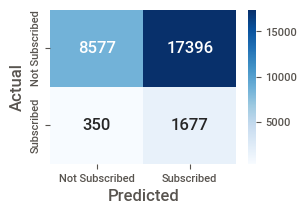

In [63]:
confusion_matrix_heatmap(y_train, y_pred_train)

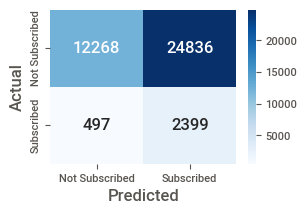

In [64]:
confusion_matrix_heatmap(y_test_total_dataset, y_pred_test_total_dataset)

In [ ]:
x_train.head()

age  balance  job  marital  education  default  housing  loan  contact
23108   57     1113    7        1          3        0        0     0        1
622     40      109    1        1          3        0        1     0        0
108     59       30    5        0          3        0        1     0        0
17129   28      649    6        0          3        0        1     0        1
25122   30      900    0        1          2        0        0     0        1

In [67]:
y_pred_train_1 = pd.DataFrame(y_pred_train, index=x_train.index, columns=['Layer1_Pred'])
x_first_out_train = pd.concat([x_train, y_pred_train_1, y_train], axis = 1)
x_first_out_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28000 entries, 23108 to 30231
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          28000 non-null  int8 
 1   balance      28000 non-null  int32
 2   job          28000 non-null  int8 
 3   marital      28000 non-null  int8 
 4   education    28000 non-null  int8 
 5   default      28000 non-null  int8 
 6   housing      28000 non-null  int8 
 7   loan         28000 non-null  int8 
 8   contact      28000 non-null  int8 
 9   Layer1_Pred  28000 non-null  int8 
 10  y            28000 non-null  int8 
dtypes: int32(1), int8(10)
memory usage: 601.6 KB


In [68]:
y_pred_test_1 = pd.DataFrame(y_pred_test_total_dataset, index=x_test_total_dataset.index, columns=['Layer1_Pred'])
x_first_out_test = pd.concat([x_test_total_dataset, pd.DataFrame(y_pred_test_1), y_test_total_dataset], axis = 1)
x_first_out_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          40000 non-null  int64
 1   balance      40000 non-null  int64
 2   job          40000 non-null  int64
 3   marital      40000 non-null  int64
 4   education    40000 non-null  int64
 5   default      40000 non-null  int64
 6   housing      40000 non-null  int64
 7   loan         40000 non-null  int64
 8   contact      40000 non-null  int64
 9   Layer1_Pred  40000 non-null  int8 
 10  y            40000 non-null  int64
dtypes: int64(10), int8(1)
memory usage: 3.1 MB


In [ ]:
x_first_out_test['Layer1_Pred'].value_counts()

Layer1_Pred
1    27235
0    12765
Name: count, dtype: int64

In [ ]:
x_first_out_test.head()

age  balance  job  marital  education  default  housing  loan  contact  \
0   58     2143    0        1          2        0        1     0        0   
1   44       29    1        0          3        0        1     0        0   
2   33        2    2        1          3        0        1     1        0   
3   47     1506    3        1          0        0        1     0        0   
4   33        1    4        0          0        0        0     0        0   

   Layer1_Pred  y  
0            0  0  
1            0  0  
2            0  0  
3            0  0  
4            0  0

In [69]:
df_second_in = pd.merge(x_first_out_test, df_first[['day', 'month', 'duration', 'campaign']], left_index = True, right_index = True, how = 'outer')
df_second_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          40000 non-null  int64 
 1   balance      40000 non-null  int64 
 2   job          40000 non-null  int64 
 3   marital      40000 non-null  int64 
 4   education    40000 non-null  int64 
 5   default      40000 non-null  int64 
 6   housing      40000 non-null  int64 
 7   loan         40000 non-null  int64 
 8   contact      40000 non-null  int64 
 9   Layer1_Pred  40000 non-null  int8  
 10  y            40000 non-null  int64 
 11  day          40000 non-null  int64 
 12  month        40000 non-null  object
 13  duration     40000 non-null  int64 
 14  campaign     40000 non-null  int64 
dtypes: int64(13), int8(1), object(1)
memory usage: 4.3+ MB


In [ ]:
df_second_in.head()

age  balance  job  marital  education  default  housing  loan  contact  \
0   58     2143    0        1          2        0        1     0        0   
1   44       29    1        0          3        0        1     0        0   
2   33        2    2        1          3        0        1     1        0   
3   47     1506    3        1          0        0        1     0        0   
4   33        1    4        0          0        0        0     0        0   

   Layer1_Pred  y  day month  duration  campaign  
0            0  0    5   may       261         1  
1            0  0    5   may       151         1  
2            0  0    5   may        76         1  
3            0  0    5   may        92         1  
4            0  0    5   may       198         1

In [70]:
month_map = {'jul' : 7, 'aug' : 8, 'jun' : 6, 'nov' : 11, 'apr' : 4, 'may' : 5, 'feb' : 2, 'jan' : 1, 'mar' : 3, 'oct' : 10, 'dec' : 12}
df_second_in['month'] = df_second_in['month'].map(month_map)
df_second_in.head()

age  balance  job  marital  education  default  housing  loan  contact  \
0   58     2143    0        1          2        0        1     0        0   
1   44       29    1        0          3        0        1     0        0   
2   33        2    2        1          3        0        1     1        0   
3   47     1506    3        1          0        0        1     0        0   
4   33        1    4        0          0        0        0     0        0   

   Layer1_Pred  y  day  month  duration  campaign  
0            0  0    5      5       261         1  
1            0  0    5      5       151         1  
2            0  0    5      5        76         1  
3            0  0    5      5        92         1  
4            0  0    5      5       198         1

##### **Total time savings in calls**

In [ ]:
print(df_second_in.groupby('Layer1_Pred')['duration'].sum())

Layer1_Pred
0    3262154
1    6930818
Name: duration, dtype: int64


In [ ]:
savings = df_second_in[df_second_in['Layer1_Pred'] == 0].groupby('Layer1_Pred')['duration'].sum()
savings_hours = savings / 3600 # To convert to hours.
savings_hours

Layer1_Pred
0    906.153889
Name: duration, dtype: float64

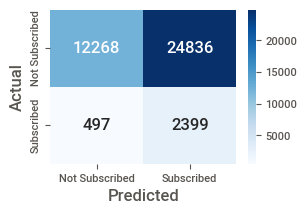

In [65]:
confusion_matrix_heatmap(y_test_total_dataset, y_pred_test_total_dataset)

**Observations:**

* In total the total savings in time by not calling class 0 customers is approximately **906 hours.**

* We still have a total of 497 class 1 missclassified customers and ~ 24 K class 1 missclassified customers. This issue will be addressed during the second layer step.

## **III. Second Layer of ML model**

In the second layer, we will evaluate an initial approach with TPOT. Since imbalance is present in the class variable of the dataset, three different methods to address this issue were implemented:

* RandomUnderSampler
* SMOTE-ENN
* SMOTE-TOMEK

In a third step, TPOT is implemented again for classification.

In [80]:
x_train_l2, x_test_l2, y_train_l2, y_test_l2 = train_test_split(df_second_in.drop(columns = ['y']), df_second_in['y'], test_size = 0.3, random_state = seed, stratify = df_second_in['y'])

In [85]:
x_test_l2['default'].value_counts()

default
0    11762
1      238
Name: count, dtype: int64

In [ ]:
y_test_l2.value_counts()

y
0    11131
1      869
Name: count, dtype: int64

### **First iteration for second layer**

In [73]:
from tpot.export_utils import set_param_recursive
import datetime

pipeline_optimizer = TPOTClassifier(generations=10, population_size=50, cv=5,
                                    random_state=seed, verbosity=2, n_jobs = -1 , scoring = 'accuracy')
# Start timer
start_time = time.time()
print("Inicio: ", datetime.datetime.fromtimestamp(start_time))
pipeline_optimizer.fit(x_train_l2, y_train_l2)
# Stop timer
end_time = time.time()
print("Fin: ", datetime.datetime.fromtimestamp(end_time))
# Calculaton of timelapse
elapsed_time = end_time - start_time
accuracy = pipeline_optimizer.score(x_test_l2, y_test_l2)
print(f"Accuracy of best model: {accuracy}")
print(f"Execution time: {elapsed_time} seconds")
pipeline_optimizer.export('tpot_digits_pipeline.py')
import joblib
joblib.dump(pipeline_optimizer.fitted_pipeline_, 'tpot_model.pkl')


Inicio:  2024-09-03 07:05:29.455323


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9356785714285716

Generation 2 - Current best internal CV score: 0.9359642857142857

Generation 3 - Current best internal CV score: 0.9359642857142857

Generation 4 - Current best internal CV score: 0.9359642857142857

Generation 5 - Current best internal CV score: 0.9359642857142857

Generation 6 - Current best internal CV score: 0.9359642857142857

Generation 7 - Current best internal CV score: 0.9367857142857143

Generation 8 - Current best internal CV score: 0.9367857142857143

Generation 9 - Current best internal CV score: 0.9367857142857143

Generation 10 - Current best internal CV score: 0.9367857142857143

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=1.0, min_samples_leaf=6, min_samples_split=8, n_estimators=100)
Fin:  2024-09-03 08:01:16.126796
Accuracy of best model: 0.9376666666666666
Execution time: 3346.67147231102 seconds


['tpot_model.pkl']

In [ ]:
import joblib
joblib.dump(pipeline_optimizer.fitted_pipeline_, 'tpot_model.pkl')

['tpot_model.pkl']

In [89]:
predictions_layer2 = pipeline_optimizer.predict(x_test_l2)
predictions_layer2.size

12000

In [90]:
print("Accuracy: ", accuracy_score(y_test_l2, predictions_layer2))

Accuracy:  0.9376666666666666


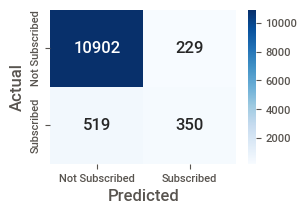

In [91]:
confusion_matrix_heatmap(y_test_l2, predictions_layer2)

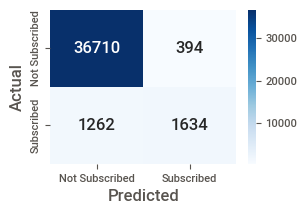

In [92]:
predictions_layer2 = pipeline_optimizer.predict(df_second_in.drop(columns = ['y']))
confusion_matrix_heatmap(df_second_in['y'], predictions_layer2)

### **RandomUnderSampler**

We will attempt to solve the imbalance issue for this dataset, by under-sampling the majority class (0) by randomly picking samples with or without replacement.



In [93]:
RUS = RandomUnderSampler(random_state = seed, sampling_strategy = 'not minority', replacement = True)
x_train_l2_RUS, y_train_l2_RUS = RUS.fit_resample(x_train_l2, y_train_l2)

In [94]:
pipeline_optimizer_RUS = TPOTClassifier(generations=10, population_size=50, cv=5,
                                    random_state=seed, verbosity=2, n_jobs = -1 , scoring = 'accuracy')
# Start timer
start_time = time.time()
print("Inicio: ", datetime.datetime.fromtimestamp(start_time))
pipeline_optimizer_RUS.fit(x_train_l2_RUS, y_train_l2_RUS)
# Stop timer
end_time = time.time()
print("Fin: ", datetime.datetime.fromtimestamp(end_time))
# Calculation of timelapse
elapsed_time_RUS = end_time - start_time
accuracy_RUS = pipeline_optimizer_RUS.score(x_test_l2, y_test_l2)
print(f"Accuracy of best model: {accuracy_RUS}")
print(f"Execution time: {elapsed_time_RUS} seconds")
pipeline_optimizer_RUS.export('tpot_digits_pipeline_RUS.py')
joblib.dump(pipeline_optimizer_RUS.fitted_pipeline_, 'tpot_model_RUS.pkl')

Inicio:  2024-09-03 08:09:38.210199


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8862903594099649

Generation 2 - Current best internal CV score: 0.8904821056156855

Generation 3 - Current best internal CV score: 0.8961550288471785

Generation 4 - Current best internal CV score: 0.8961550288471785

Generation 5 - Current best internal CV score: 0.8966482470962536

Generation 6 - Current best internal CV score: 0.8966482470962536

Generation 7 - Current best internal CV score: 0.8966482470962536

Generation 8 - Current best internal CV score: 0.8966482470962536

Generation 9 - Current best internal CV score: 0.8966482470962536

Generation 10 - Current best internal CV score: 0.8966482470962536

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.9000000000000001, min_samples_leaf=2, min_samples_split=6, n_estimators=100)
Fin:  2024-09-03 08:15:36.996418
Accuracy of best model: 0.8589166666666667
Execution time: 358.78621888160706 seconds


['tpot_model_RUS.pkl']

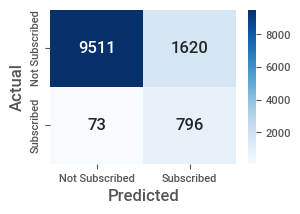

In [95]:
predictions_layer2_RUS = pipeline_optimizer_RUS.predict(x_test_l2)
confusion_matrix_heatmap(y_test_l2, predictions_layer2_RUS)

In [96]:
print("Accuracy: ", accuracy_score(y_test_l2, predictions_layer2_RUS))

Accuracy:  0.8589166666666667


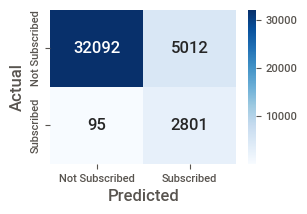

None
Accuracy:  0.872325


In [97]:
x_test_total_dataset_l2 = df_second_in.copy().drop(columns = ['y'])
y_test_total_dataset_l2 = df_second_in['y']
predictions_layer2_RUS_total_dataset = pipeline_optimizer_RUS.predict(x_test_total_dataset_l2)
print(confusion_matrix_heatmap(y_test_total_dataset_l2, predictions_layer2_RUS_total_dataset))
print("Accuracy: ", accuracy_score(y_test_total_dataset_l2, predictions_layer2_RUS_total_dataset))


In [98]:
print("Accuracy: ", accuracy_score(y_test_total_dataset_l2, predictions_layer2_RUS_total_dataset))

Accuracy:  0.872325


### **SMOTE ENN**

In [99]:
smote_enn = SMOTEENN(random_state = seed, sampling_strategy = 'not minority')
#sampling_strategy='auto', random_state=None, smote=None, enn=None, n_jobs=None
x_train_l2_SMOTEENN, y_train_l2_SMOTEENN = smote_enn.fit_resample(x_train_l2, y_train_l2)

In [100]:
pipeline_optimizer_SMOTEENN = TPOTClassifier(generations=10, population_size=50, cv=5,
                                    random_state=seed, verbosity=2, n_jobs = -1 , scoring = 'accuracy')
# Start of chronometer
start_time = time.time()
print("Start: ", datetime.datetime.fromtimestamp(start_time))
pipeline_optimizer_SMOTEENN.fit(x_train_l2_SMOTEENN, y_train_l2_SMOTEENN)
# End of chronometer
end_time = time.time()
print("End: ", datetime.datetime.fromtimestamp(end_time))
# Calculation of timelapse
elapsed_time_SMOTEENN = end_time - start_time
accuracy_SMOTEENN = pipeline_optimizer_SMOTEENN.score(x_test_l2, y_test_l2)
print(f"Accuracy of best model: {accuracy_SMOTEENN}")
print(f"Execution time: {elapsed_time_SMOTEENN} seconds")
pipeline_optimizer_SMOTEENN.export('tpot_digits_pipeline_SMOTEENN.py')
joblib.dump(pipeline_optimizer_SMOTEENN.fitted_pipeline_, 'tpot_model_SMOTEENN.pkl')

Start:  2024-09-03 08:20:28.826842


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9986937211431035

Generation 2 - Current best internal CV score: 0.9987808007130912

Generation 3 - Current best internal CV score: 0.9987808007130912

Generation 4 - Current best internal CV score: 0.9987808007130912

Generation 5 - Current best internal CV score: 0.9987808007130912

Generation 6 - Current best internal CV score: 0.9987808007130912

Generation 7 - Current best internal CV score: 0.9987808007130912

Generation 8 - Current best internal CV score: 0.9987808007130912

Generation 9 - Current best internal CV score: 0.9987808007130912

Generation 10 - Current best internal CV score: 0.9987808007130912

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=1, p=2, weights=distance)
End:  2024-09-03 08:30:40.792680
Accuracy of best model: 0.9304166666666667
Execution time: 611.965838432312 seconds


['tpot_model_SMOTEENN.pkl']

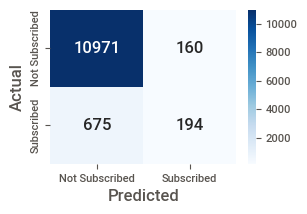

In [101]:
predictions_layer2_SMOTEENN = pipeline_optimizer_SMOTEENN.predict(x_test_l2)
confusion_matrix_heatmap(y_test_l2, predictions_layer2_SMOTEENN)

In [102]:
print("Accuracy: ", accuracy_score(y_test_l2, predictions_layer2_SMOTEENN))

Accuracy:  0.9304166666666667


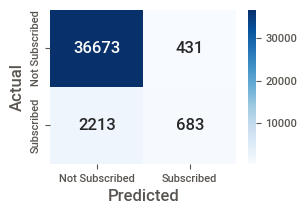

None
Accuracy:  0.9339


In [103]:
predictions_layer2_SMOTEENN_total_dataset = pipeline_optimizer_SMOTEENN.predict(x_test_total_dataset_l2)
print(confusion_matrix_heatmap(y_test_total_dataset_l2, predictions_layer2_SMOTEENN_total_dataset))
print("Accuracy: ", accuracy_score(y_test_total_dataset_l2, predictions_layer2_SMOTEENN_total_dataset))

### **SMOTE TOMEK**

In [104]:
smote_tomek = SMOTETomek(random_state = seed)
x_train_l2_SMOTE_TOMEK, y_train_l2_SMOTE_TOMEK= smote_tomek.fit_resample(x_train_l2, y_train_l2)

In [105]:
pipeline_optimizer_SMOTE_TOMEK= TPOTClassifier(generations=10, population_size=50, cv=5,
                                    random_state=seed, verbosity=2, n_jobs = -1 , scoring = 'accuracy')
# Start timer
start_time = time.time()
print("Start: ", datetime.datetime.fromtimestamp(start_time))
pipeline_optimizer_SMOTE_TOMEK.fit(x_train_l2_SMOTE_TOMEK, y_train_l2_SMOTE_TOMEK)
# Stop timer
end_time = time.time()
print("End: ", datetime.datetime.fromtimestamp(end_time))
# Total time calculation
elapsed_time_SMOTE_TOMEK = end_time - start_time
accuracy_SMOTE_TOMEK = pipeline_optimizer_SMOTE_TOMEK.score(x_test_l2, y_test_l2)
print(f"Accuracy of best model: {accuracy_SMOTE_TOMEK}")
print(f"Execution time: {elapsed_time_SMOTE_TOMEK} seconds")
pipeline_optimizer_SMOTE_TOMEK.export('tpot_digits_pipeline_SMOTE_TOMEK.py')
joblib.dump(pipeline_optimizer_SMOTE_TOMEK.fitted_pipeline_, 'tpot_model_SMOTE_TOMEK.pkl')

Start:  2024-09-03 08:35:07.389303


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9460026679429736

Generation 2 - Current best internal CV score: 0.9525710858797003

Generation 3 - Current best internal CV score: 0.9534729697780495

Generation 4 - Current best internal CV score: 0.9534729697780495

Generation 5 - Current best internal CV score: 0.9536494826535653

Generation 6 - Current best internal CV score: 0.9536494826535653

Generation 7 - Current best internal CV score: 0.9556493846239604

Generation 8 - Current best internal CV score: 0.9559630620604285

Generation 9 - Current best internal CV score: 0.9559630620604285

Generation 10 - Current best internal CV score: 0.9572179217339324

Best pipeline: GradientBoostingClassifier(RobustScaler(input_matrix), learning_rate=0.5, max_depth=9, max_features=0.7500000000000001, min_samples_leaf=20, min_samples_split=5, n_estimators=100, subsample=0.8500000000000001)
End:  2024-09-03 09:46:02.056172
Accuracy of best model: 0.9163333333333333
Execution time: 4254.666869

['tpot_model_SMOTE_TOMEK.pkl']

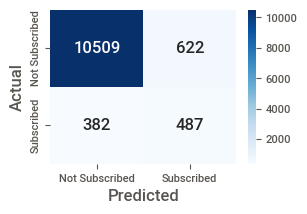

In [106]:
predictions_layer2_SMOTE_TOMEK = pipeline_optimizer_SMOTE_TOMEK.predict(x_test_l2)
confusion_matrix_heatmap(y_test_l2, predictions_layer2_SMOTE_TOMEK)

In [107]:
print("Accuracy: ", accuracy_score(y_test_l2, predictions_layer2_SMOTE_TOMEK))

Accuracy:  0.9163333333333333


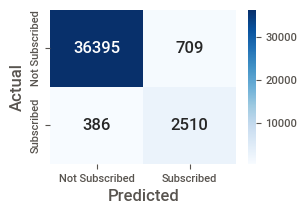

None
Accuracy:  0.972625


In [108]:
predictions_layer2_SMOTE_TOMEK_total_dataset = pipeline_optimizer_SMOTE_TOMEK.predict(x_test_total_dataset_l2)
print(confusion_matrix_heatmap(y_test_total_dataset_l2, predictions_layer2_SMOTE_TOMEK_total_dataset))
print("Accuracy: ", accuracy_score(y_test_total_dataset_l2, predictions_layer2_SMOTE_TOMEK_total_dataset))

### **Putting all predictions together**

In [ ]:
final_predictions = pd.concat([x_test_total_dataset_l2, y_test_total_dataset_l2, pd.DataFrame(predictions_layer2, columns = ['y_pred']),pd.DataFrame(predictions_layer2_RUS_total_dataset, columns = ['y_pred_RUS']),pd.DataFrame(predictions_layer2_SMOTEENN_total_dataset, columns = ['y_pred_SMOTEENN']), pd.DataFrame(predictions_layer2_SMOTE_TOMEK_total_dataset, columns = ['y_pred_SMOTE_TOMEK'])], axis = 1)
final_predictions.head()

age  balance  job  marital  education  default  housing  loan  contact  \
0   58     2143    0        1          2        0        1     0        0   
1   44       29    1        0          3        0        1     0        0   
2   33        2    2        1          3        0        1     1        0   
3   47     1506    3        1          0        0        1     0        0   
4   33        1    4        0          0        0        0     0        0   

   Layer1_Pred  day  month  duration  campaign  y  y_pred  y_pred_RUS  \
0            0    5      5       261         1  0       0           0   
1            0    5      5       151         1  0       0           0   
2            0    5      5        76         1  0       0           0   
3            0    5      5        92         1  0       0           0   
4            0    5      5       198         1  0       0           0   

   y_pred_SMOTEENN  y_pred_SMOTE_TOMEK  
0                0                   0  
1                0                   0  
2                0                   0  
3                0                   0  
4                0                   0

In [ ]:
final_predictions.to_csv('final_predictions.csv', index = True)

## **IV. SHAP Analysis**

In [ ]:
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 0.076612


In [ ]:
def predict_fn(data):
    return pipeline_optimizer_RUS.predict(data)

In [ ]:
explainer = shap.Explainer(model = predict_fn, masker = x_test_total_dataset_l2)

In [ ]:
explainer.__class__

shap.explainers._permutation.PermutationExplainer

In [ ]:
shap_values =explainer(x_test_total_dataset_l2)

PermutationExplainer explainer: 40001it [4:42:43,  2.36it/s]


In [ ]:
#shap_values = explainer(x_train_l2)
shap_df = pd.DataFrame(shap_values.values, columns=x_test_total_dataset_l2.columns)
shap_df['prediction'] = predict_fn(x_test_total_dataset_l2)
shap_df = pd.concat([shap_df, x_test_total_dataset_l2.reset_index(drop=True)], axis=1)
shap_df.to_csv('shap_analysis.csv', index=False)

In [ ]:
print(type(shap_values[0]))

<class 'shap._explanation.Explanation'>


### **Local explanations**

In [ ]:
shap_value = shap_values[0]

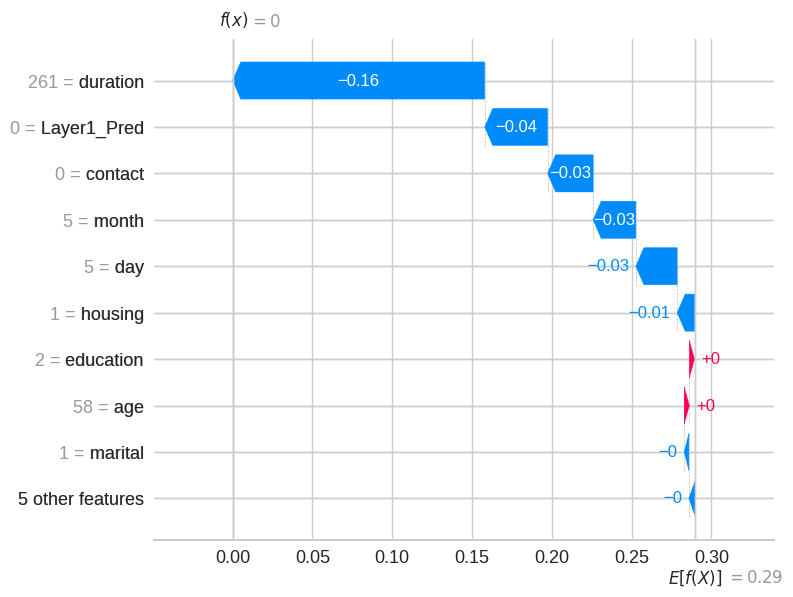

In [ ]:
shap.plots.waterfall(shap_values[0])

### **Force Plot**

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])

### **Global explanations**

#### **Bar plot**

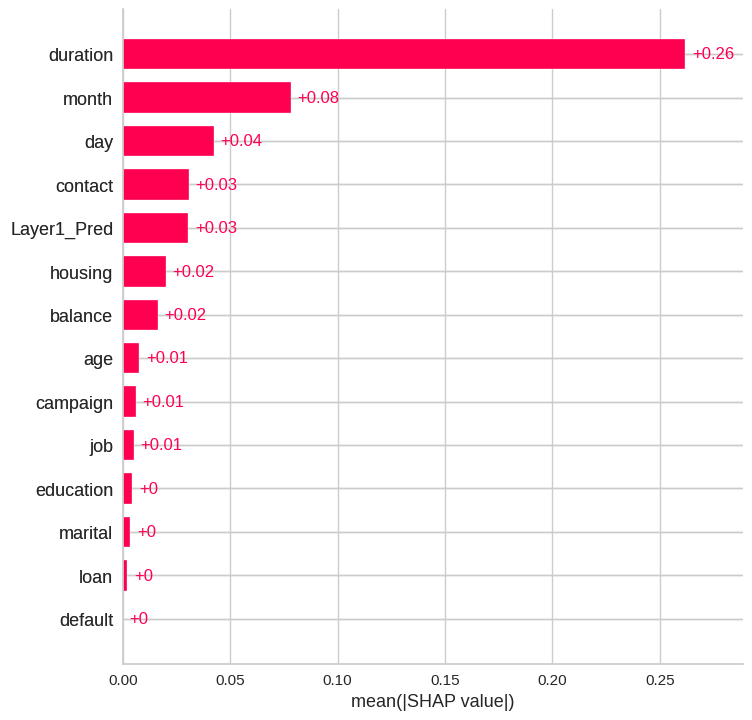

In [ ]:
shap.plots.bar(shap_values, max_display = 14)

#### **Beeswarm Plot**

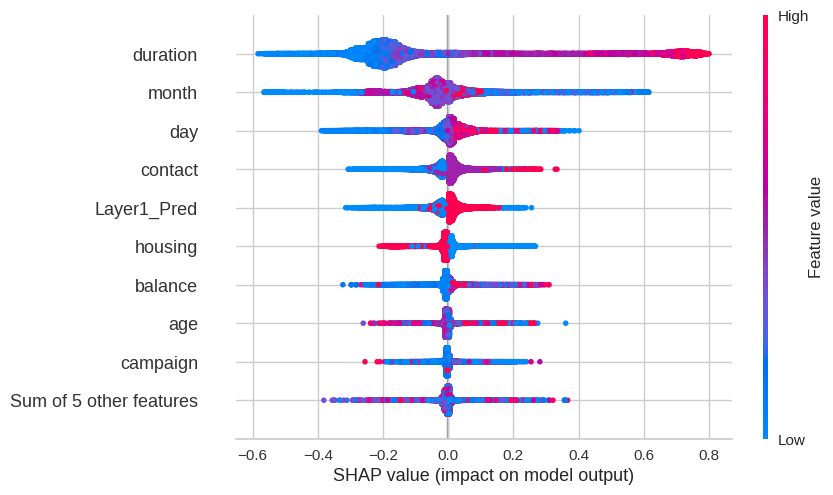

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0:1000])

#### **Violin Plot**

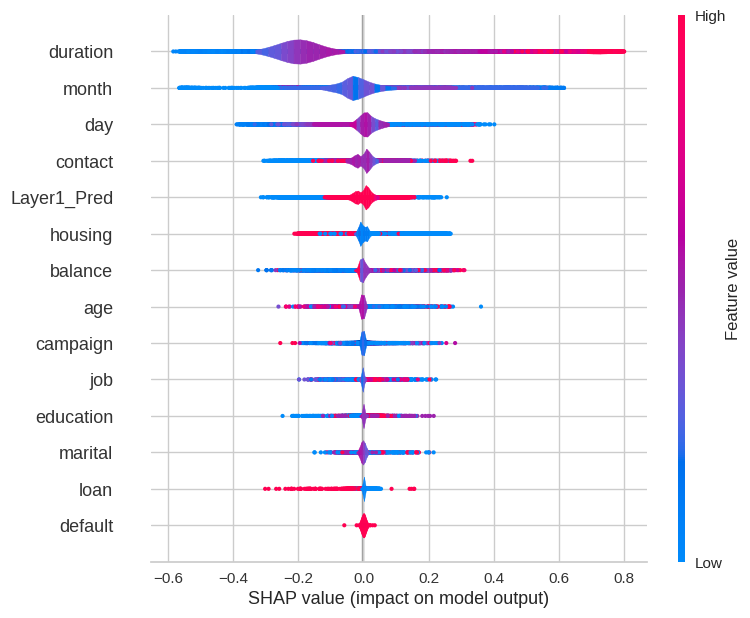

In [ ]:
shap.violin_plot(shap_values)

## **V. Unsupervised ML for segmentation**

For this analysis, we will take into account only those **customers who have subscribed to the investment.**

In [ ]:
# Select the customers who have subscribed
df_subscribed_for_clust = df_first[df_first['y'] == 1]

In [ ]:
from pycaret.clustering import *
exp_cluster = setup(df_subscribed_for_clust, normalize = False, session_id = seed, ignore_features = ['y'], pca = False) # initialize setup

In [ ]:
kmeans = exp_cluster.create_model('kmeans') # Create k-means model

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
kmeans_predictions = predict_model(kmeans, data = df_subscribed_for_clust) # Clusters on subscribers

In [ ]:
df_subscribed_cluster = pd.concat([df_subscribed_for_clust, kmeans_predictions['Cluster']], axis = 1)
df_subscribed_cluster.rename(columns = {'Cluster' : 'Cluster_kmeans'}, inplace = True)

<Figure size 500x500 with 0 Axes>

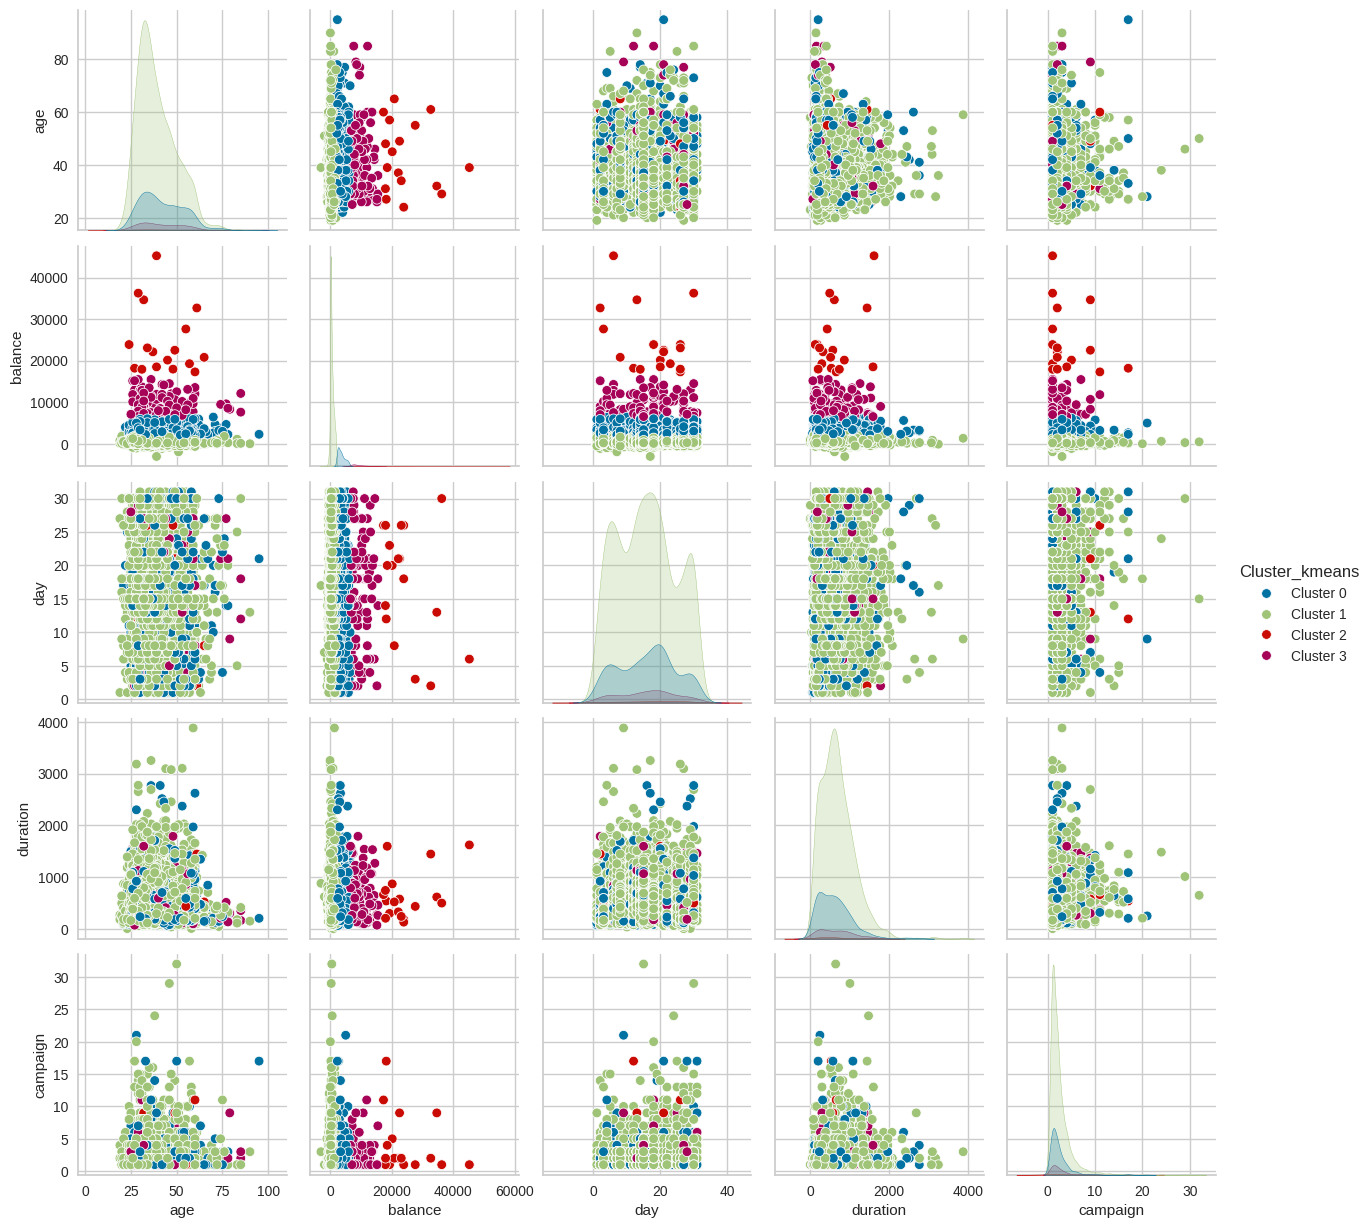

In [ ]:
num_vars3 = ['age', 'balance', 'day', 'duration', 'campaign', 'Cluster_kmeans']
plt.figure(figsize = (5, 5))
sns.pairplot(df_subscribed_cluster[num_vars3], hue = 'Cluster_kmeans')
plt.show()

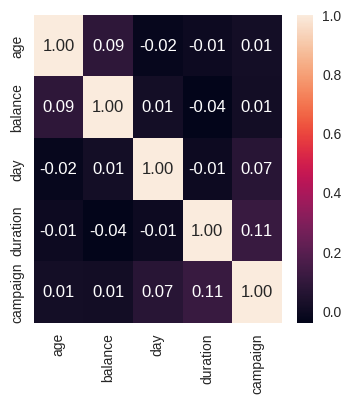

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(df_subscribed_cluster[num_vars].corr(), annot = True, fmt = ".2f")
plt.show()

**Observations:**

* There are no relevant, strong correlations among the numerical features.

In [ ]:
evaluate_model(kmeans) # Evaluate model

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
kmeans_df = assign_model(kmeans) # Assign clusters to dataframe

In [ ]:
kmeans_df.head()

age  job  marital  education  default  balance  housing  loan  contact  \
83    59    6        1          3        0     2343        1     0        0   
86    56    6        1          3        0       45        0     0        0   
87    41    1        1          3        0     1270        1     0        0   
129   55    7        1          3        0     2476        1     0        0   
168   54    6        1          2        0      184        0     0        0   

     day month  duration  campaign    Cluster  
83     5   may      1042         1  Cluster 0  
86     5   may      1467         1  Cluster 1  
87     5   may      1389         1  Cluster 1  
129    5   may       579         1  Cluster 0  
168    5   may       673         2  Cluster 1

In [ ]:
save_model(kmeans, 'kmeans_model') # Save model

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'job', 'marital',
                                              'education', 'default', 'balance',
                                              'housing', 'loan', 'contact',
                                              'day', 'duration', 'campaign'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['month'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['month'],
                                     transformer=OneHotEncoder(cols=['month'],
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
        

In [ ]:
kmeans_clusters = kmeans_predictions['Cluster']

**Observations:**

* Clusters seem to be built mainly in function of the balance, in 4 different ranges:

1. **Cluster 0:** Those customers with balance less than or equal to ~2K.
2. **Cluster 1:** Customers with balance greater than ~2K and less than or equal to ~ 6.5K.
3. **Cluster 2:** Customers with balance greater than ~6.5K and less than or equal to ~16.4K
4. **Cluaster 3:** Customer with balance greater than ~16.4K.

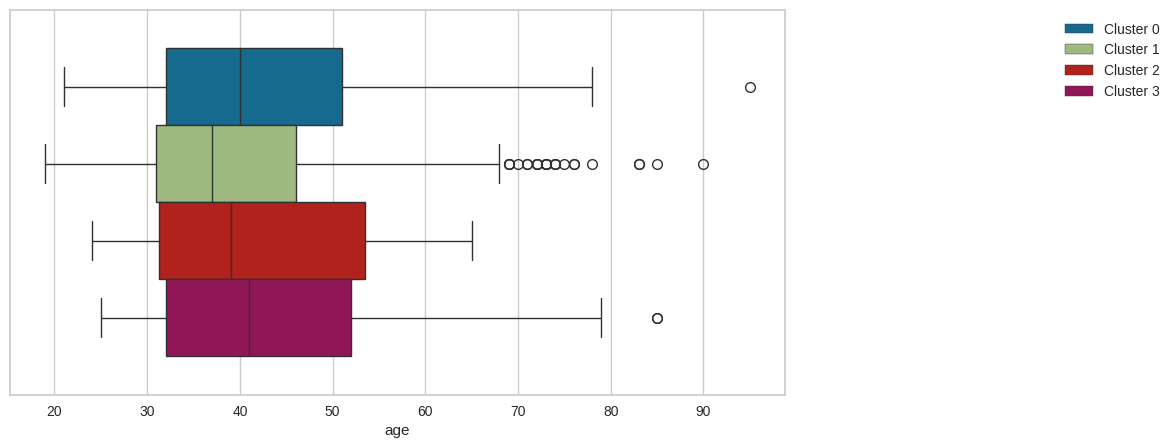

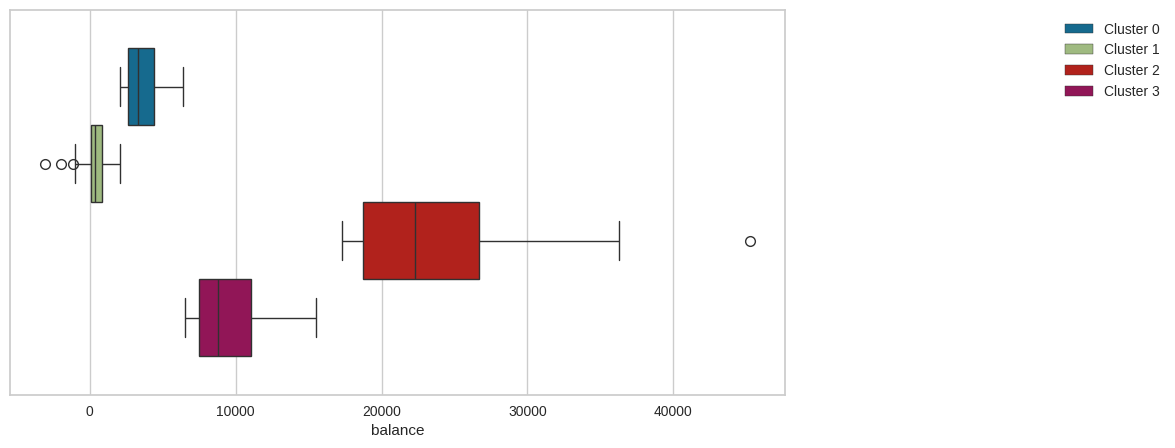

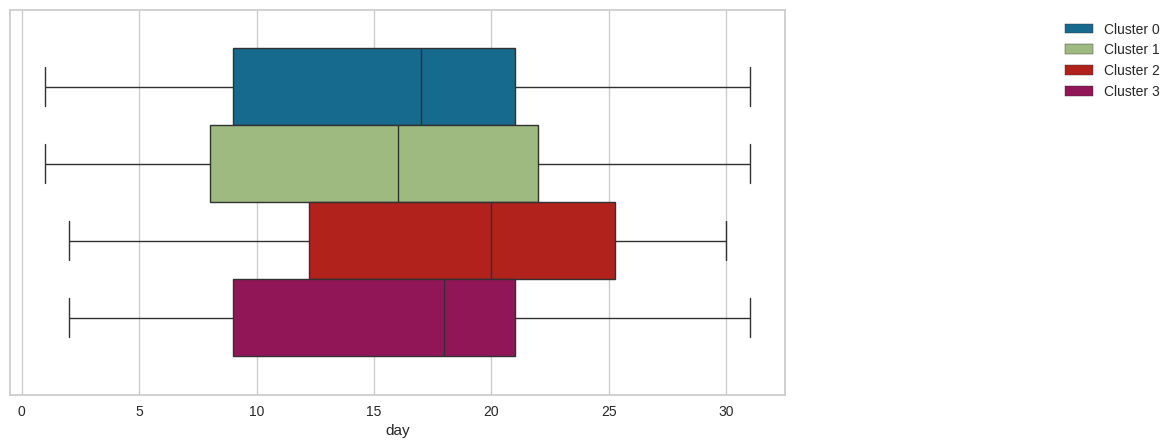

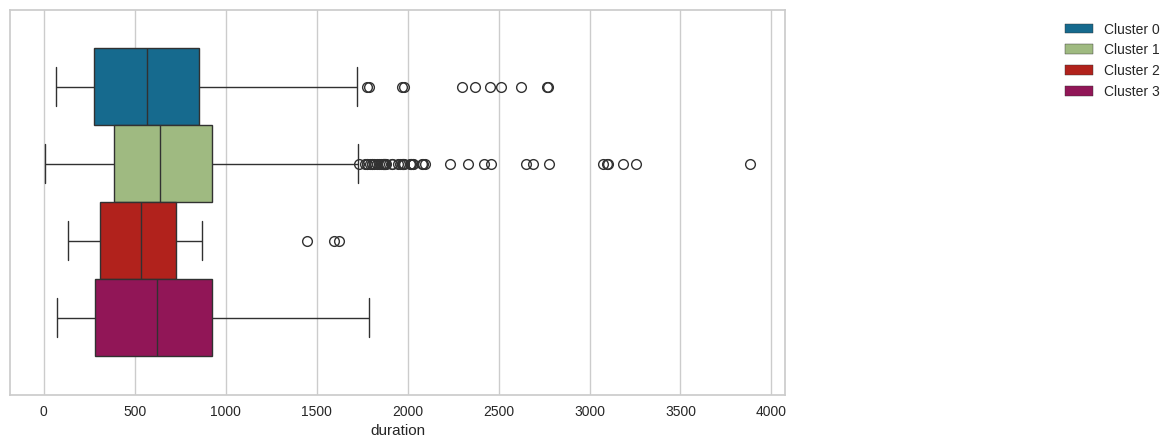

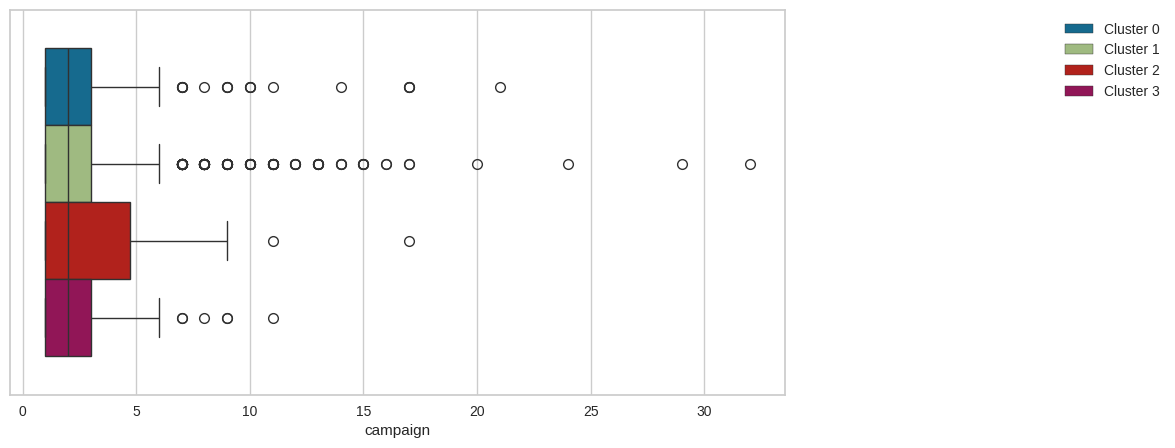

In [ ]:
for col in num_vars:
  plt.figure(figsize = (10, 5))
  sns.boxplot(data = df_subscribed_cluster, x = col, hue = 'Cluster')
  plt.legend(loc = 'upper right', bbox_to_anchor = (1.5, 1))
  plt.show()

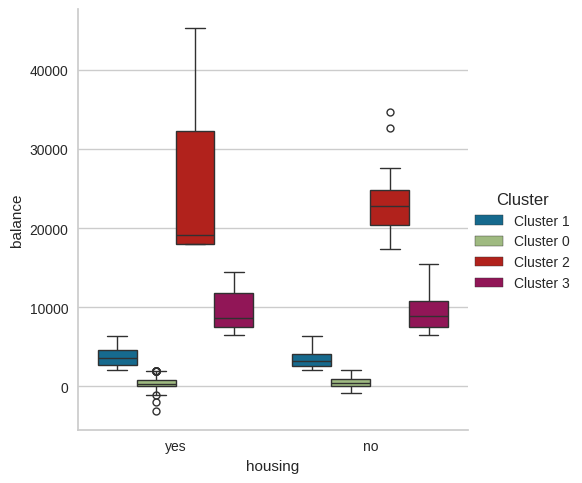

In [ ]:
sns.catplot(x = 'housing', y = 'balance', hue = 'Cluster', kind = 'box', data = df_subscribed_cluster)
plt.show()

**Observations:**

* Those customers in Cluster 2 that hold housing debt seem to have higher balances than their no-housing-debt counterpart.

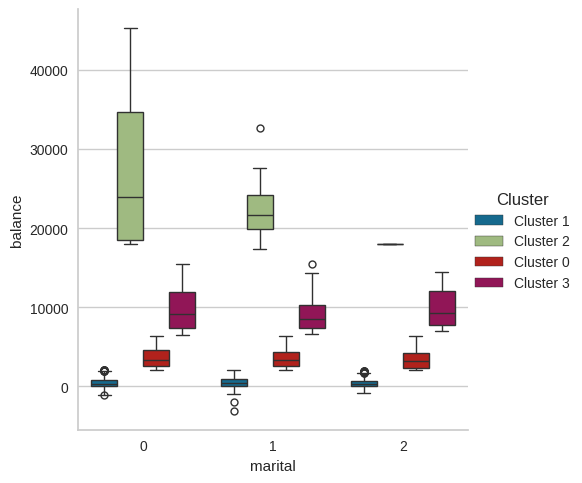

In [ ]:
sns.catplot(x = 'marital', y = 'balance', hue = 'Cluster', kind = 'box', data = df_subscribed_cluster)
plt.show()

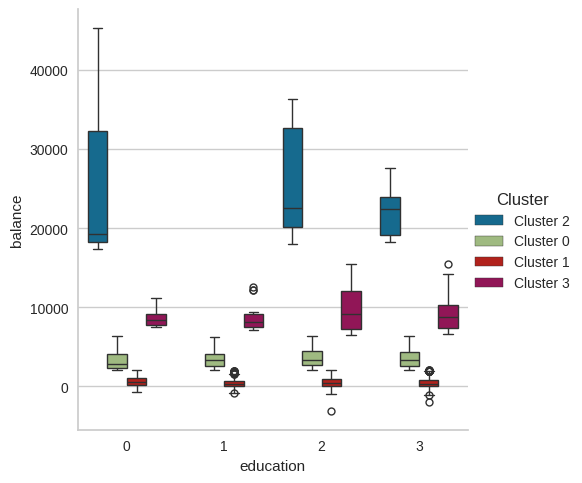

In [ ]:
sns.catplot(x = 'education', y = 'balance', hue = 'Cluster', kind = 'box', data = df_subscribed_cluster)
plt.show()

**Observations:**

* Cluster 2 customers with **tertiary education** seemingly present higher balances than primary and secondary. Unknown-education customers might as well be included within this class.

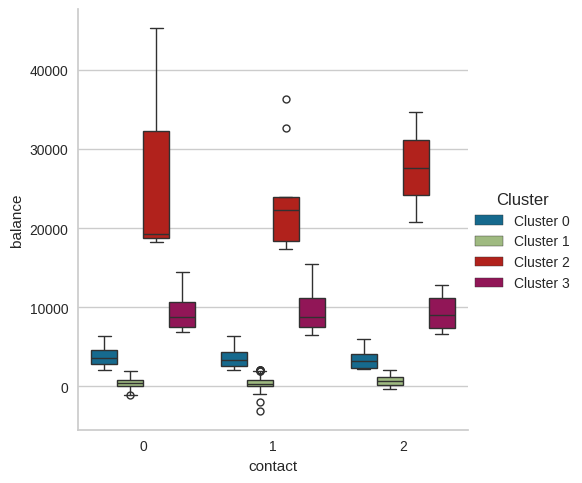

In [ ]:
sns.catplot(x = 'contact', y = 'balance', hue = 'Cluster', kind = 'box', data = df_subscribed_cluster)
plt.show()

**Observations:**

* Cluster 2 customers contacted via telephone have higher balances. Unknown-type customers might as well be included within this class.

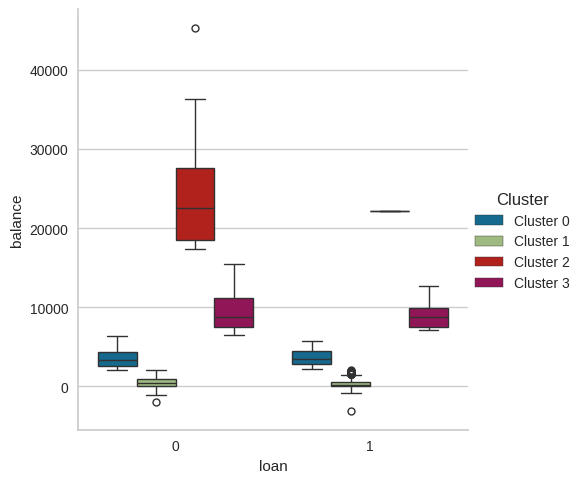

In [ ]:
sns.catplot(x = 'loan', y = 'balance', hue = 'Cluster', kind = 'box', data = df_subscribed_cluster)
plt.show()

**Observations:**

* Those Cluster 2 customers with no previous loans have higher balances than those who do.

### **Which cluster shall we keep calling?**

By looking at the variability of *balance*, *age*, *duration* and *campaign*,  **Cluster 2** holds the highest attractiveness:
  * The range of age goes from ~24 to ~65, it seems that this cluster includes economically-active customers with high values in balance.
  * Number of calls tend to be 2 and 9 before closing the sale.
  * Preferably, to maximize potential deposit amount, we will contact those cluster 2 customers that are single, with tertiary education, and with no previous loan history.

**Observations:**



### **TSNE clustering**

In [ ]:
month_map = {'jul' : 7, 'aug' : 8, 'jun' : 6, 'nov' : 11, 'apr' : 4, 'may' : 5, 'feb' : 2, 'jan' : 1, 'mar' : 3, 'oct' : 10, 'dec' : 12}
df_subscribed_cluster['month'] = df_subscribed_cluster['month'].map(month_map)

In [ ]:
df_subscribed_cluster.head()

age  job  marital  education  default  balance  housing  loan  contact  \
83    59    6        1          3        0     2343        1     0        0   
86    56    6        1          3        0       45        0     0        0   
87    41    1        1          3        0     1270        1     0        0   
129   55    7        1          3        0     2476        1     0        0   
168   54    6        1          2        0      184        0     0        0   

     day  month  duration  campaign  y Cluster_kmeans  
83     5    NaN      1042         1  1      Cluster 0  
86     5    NaN      1467         1  1      Cluster 1  
87     5    NaN      1389         1  1      Cluster 1  
129    5    NaN       579         1  1      Cluster 0  
168    5    NaN       673         2  1      Cluster 1

In [ ]:
original_indexes = df_subscribed_cluster.index
tsne = TSNE(n_components=2, random_state=seed)
data_tsne = tsne.fit_transform(df_subscribed_cluster.drop(columns = ['y', 'Cluster_kmeans']))
data_tsne = pd.DataFrame(data_tsne, index = original_indexes, columns=['t-SNE 1', 't-SNE 2'])
data_tsne.head()

t-SNE 1    t-SNE 2
83   32.243359  13.590558
86   -8.584408  32.302795
87   11.367416  14.774328
129  40.263283  11.670314
168 -34.890968  -0.635893

In [ ]:
from pycaret import *
exp_tsne = setup(data_tsne, normalize = False, session_id = seed, ignore_features = ['y'], pca = False)


In [ ]:
kmeans = exp_tsne.create_model('kmeans') # Create k-means model

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from pycaret.clustering import predict_model
predictions = predict_model(data = data_tsne, model = kmeans)
predictions.rename(columns = {'Cluster' : 'Cluster_tsne'}, inplace = True)
predictions.head()

t-SNE 1    t-SNE 2 Cluster_tsne
83   32.243359  13.590558    Cluster 0
86   -8.584408  32.302795    Cluster 2
87   11.367416  14.774328    Cluster 2
129  40.263283  11.670314    Cluster 0
168 -34.890968  -0.635893    Cluster 1

In [ ]:
df_subscribed_cluster2 = pd.merge(df_subscribed_cluster, predictions, left_index = True, right_index = True, how = 'outer' )
df_subscribed_cluster2.rename(columns = {'Cluster 1' : 'Cluster 2', 'Cluster 2' : 'Cluster 1'}, inplace = True)
df_subscribed_cluster2.head()

age  job  marital  education  default  balance  housing  loan  contact  \
83    59    6        1          3        0     2343        1     0        0   
86    56    6        1          3        0       45        0     0        0   
87    41    1        1          3        0     1270        1     0        0   
129   55    7        1          3        0     2476        1     0        0   
168   54    6        1          2        0      184        0     0        0   

     day  month  duration  campaign  y Cluster_kmeans    t-SNE 1    t-SNE 2  \
83     5      5      1042         1  1      Cluster 0  32.243359  13.590558   
86     5      5      1467         1  1      Cluster 1  -8.584408  32.302795   
87     5      5      1389         1  1      Cluster 1  11.367416  14.774328   
129    5      5       579         1  1      Cluster 0  40.263283  11.670314   
168    5      5       673         2  1      Cluster 1 -34.890968  -0.635893   

    Cluster_tsne  
83     Cluster 0  
86     Cluster 2  
87     Cluster 2  
129    Cluster 0  
168    Cluster 1

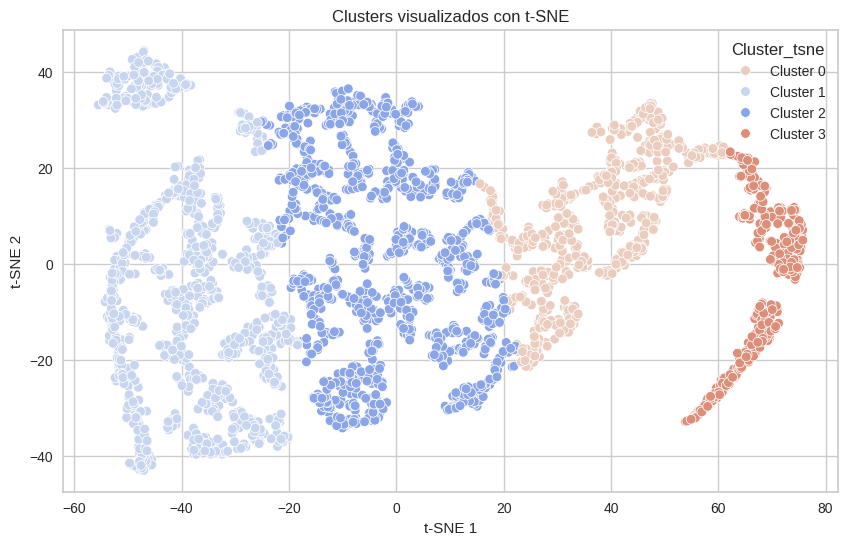

In [ ]:
custom_palette = {
    'Cluster 1' : '#c7d5ee',
    'Cluster 2' : '#8ba5e9',
    'Cluster 0' : '#eacdbe',
    'Cluster 3' : '#dd8e78'
}
plt.figure(figsize=(10, 6))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Cluster_tsne', data=df_subscribed_cluster2, palette=custom_palette, hue_order= ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('Clusters visualizados con t-SNE')
plt.show()

### **UMAP**

In [ ]:
from umap import UMAP
from pycaret.clustering import setup, create_model, plot_model
import pandas as pd

# Apply UMAP manually
original_indexes = df_subscribed_cluster.index
umap = UMAP(n_components=2)
data_umap = umap.fit_transform(df_subscribed_cluster2.drop(columns = ['y', 'Cluster_kmeans', 'Cluster_tsne', 't-SNE 1', 't-SNE 2']))

# UMAP transformed dataframe
data_umap_df = pd.DataFrame(data_umap, columns=['UMAP 1', 'UMAP 2'], index = original_indexes)
# Paso 2: Pycaret setup
clf1 = setup(data_umap_df, normalize=False, pca = False, session_id = seed, ignore_features = ['y'])

# kmeans clustering
kmeans = create_model('kmeans')

# visualization
#plot_model(kmeans, plot='cluster')

predictions = predict_model(kmeans, data=data_umap_df)


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
predictions.rename(columns = {'Cluster' : 'Cluster_UMAP'}, inplace = True)
df_subscribed_cluster3 = pd.merge(df_subscribed_cluster2, predictions, left_index = True, right_index = True, how = 'outer' )
df_subscribed_cluster3.head()

age  job  marital  education  default  balance  housing  loan  contact  \
83    59    6        1          3        0     2343        1     0        0   
86    56    6        1          3        0       45        0     0        0   
87    41    1        1          3        0     1270        1     0        0   
129   55    7        1          3        0     2476        1     0        0   
168   54    6        1          2        0      184        0     0        0   

     day  month  duration  campaign  y Cluster_kmeans    t-SNE 1    t-SNE 2  \
83     5      5      1042         1  1      Cluster 0  32.243359  13.590558   
86     5      5      1467         1  1      Cluster 1  -8.584408  32.302795   
87     5      5      1389         1  1      Cluster 1  11.367416  14.774328   
129    5      5       579         1  1      Cluster 0  40.263283  11.670314   
168    5      5       673         2  1      Cluster 1 -34.890968  -0.635893   

    Cluster_tsne     UMAP 1    UMAP 2 Cluster_UMAP  
83     Cluster 0   3.098387 -2.025063    Cluster 0  
86     Cluster 2   5.482507  5.501154    Cluster 2  
87     Cluster 2   6.257864  1.304882    Cluster 0  
129    Cluster 0   1.765023 -3.585091    Cluster 0  
168    Cluster 1  11.737891  8.517244    Cluster 1

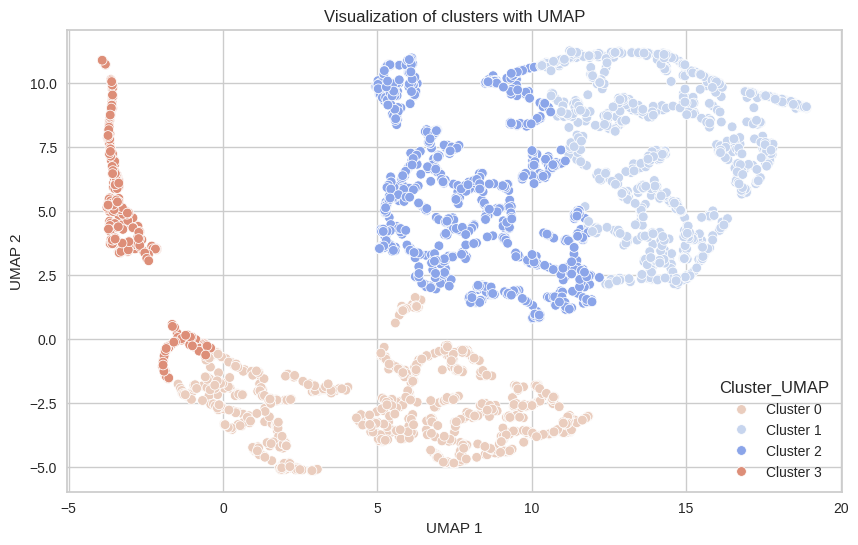

In [ ]:
custom_palette = {
    'Cluster 1' : '#c7d5ee',
    'Cluster 2' : '#8ba5e9',
    'Cluster 0' : '#eacdbe',
    'Cluster 3' : '#dd8e78'
}
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP 1', y='UMAP 2', hue='Cluster_UMAP', data=df_subscribed_cluster3, palette=custom_palette, hue_order= ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('Visualization of clusters with UMAP')
plt.show()

### **How the different Clustering methods relate?**

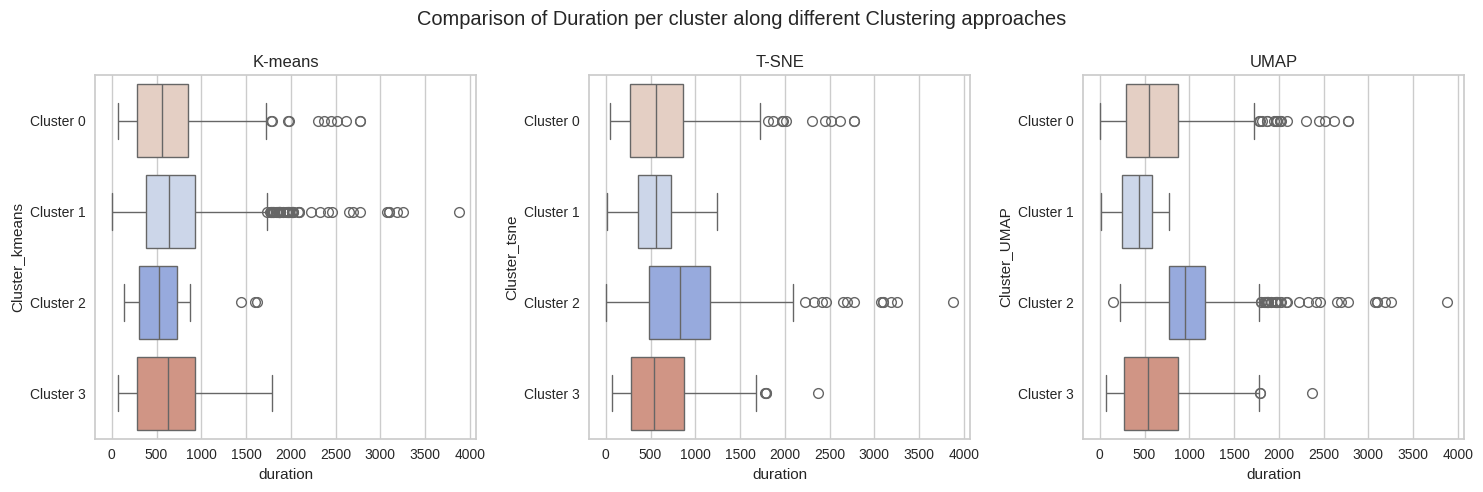

In [ ]:
custom_palette = {
    'Cluster 1' : '#c7d5ee',
    'Cluster 2' : '#8ba5e9',
    'Cluster 0' : '#eacdbe',
    'Cluster 3' : '#dd8e78'
}
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

# Panel 1
sns.boxplot(data = df_subscribed_cluster3, x = 'duration', y = 'Cluster_kmeans', palette = custom_palette, ax = axes[0],
            order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[0].set_title('K-means')
# Panel 2
sns.boxplot(data = df_subscribed_cluster3, x = 'duration', y = 'Cluster_tsne', palette = custom_palette, ax = axes[1],
            order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[1].set_title('T-SNE')
# Panel 3
sns.boxplot(data = df_subscribed_cluster3, x = 'duration', y = 'Cluster_UMAP', palette = custom_palette, ax = axes[2],
            order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[2].set_title('UMAP')

fig.suptitle("Comparison of Duration per cluster along different Clustering approaches")
plt.tight_layout()
plt.show()

**Observations:**

* The three methods provide very similar clustering results.
*

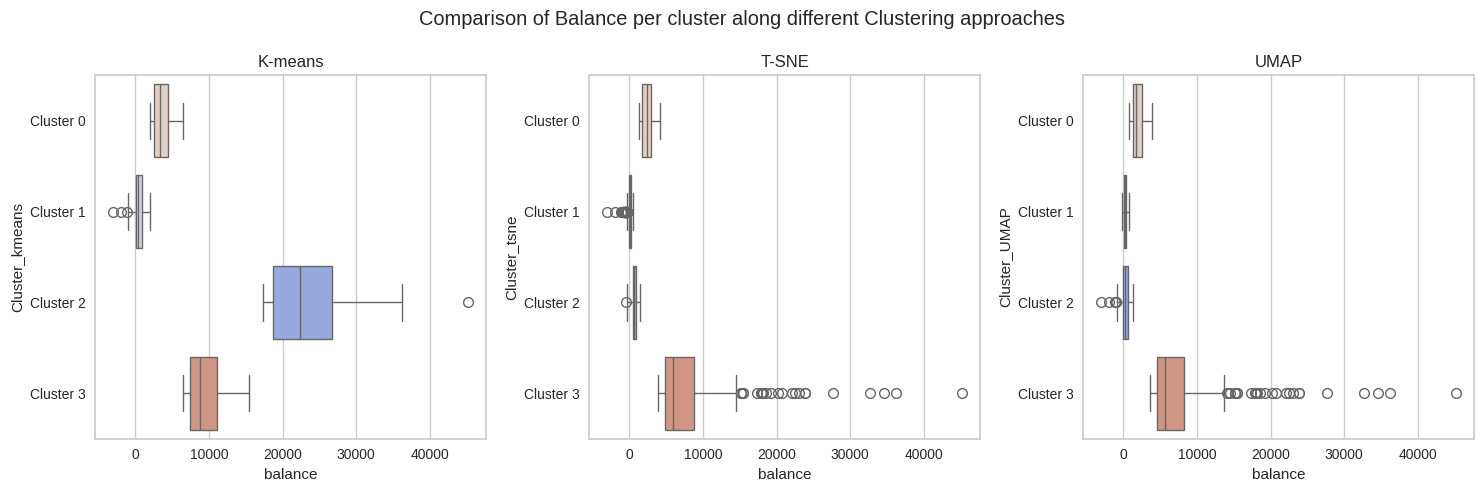

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

# Panel 1
sns.boxplot(data = df_subscribed_cluster3, x = 'balance', y = 'Cluster_kmeans', palette = custom_palette, ax = axes[0],
            order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[0].set_title('K-means')
# Panel 2
sns.boxplot(data = df_subscribed_cluster3, x = 'balance', y = 'Cluster_tsne', palette = custom_palette, ax = axes[1],
            order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[1].set_title('T-SNE')
# Panel 3
sns.boxplot(data = df_subscribed_cluster3, x = 'balance', y = 'Cluster_UMAP', palette = custom_palette, ax = axes[2],
            order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[2].set_title('UMAP')

fig.suptitle("Comparison of Balance per cluster along different Clustering approaches")
plt.tight_layout()
plt.show()

In [ ]:
palette = sns.color_palette("coolwarm", n_colors = 10)
hex_colors = palette.as_hex()
for color in hex_colors:
  print(color)

#5673e0
#7597f6
#94b6ff
#b5cdfa
#d1dae9
#e8d6cc
#f5c1a9
#f6a283
#ea7b60
#d44e41


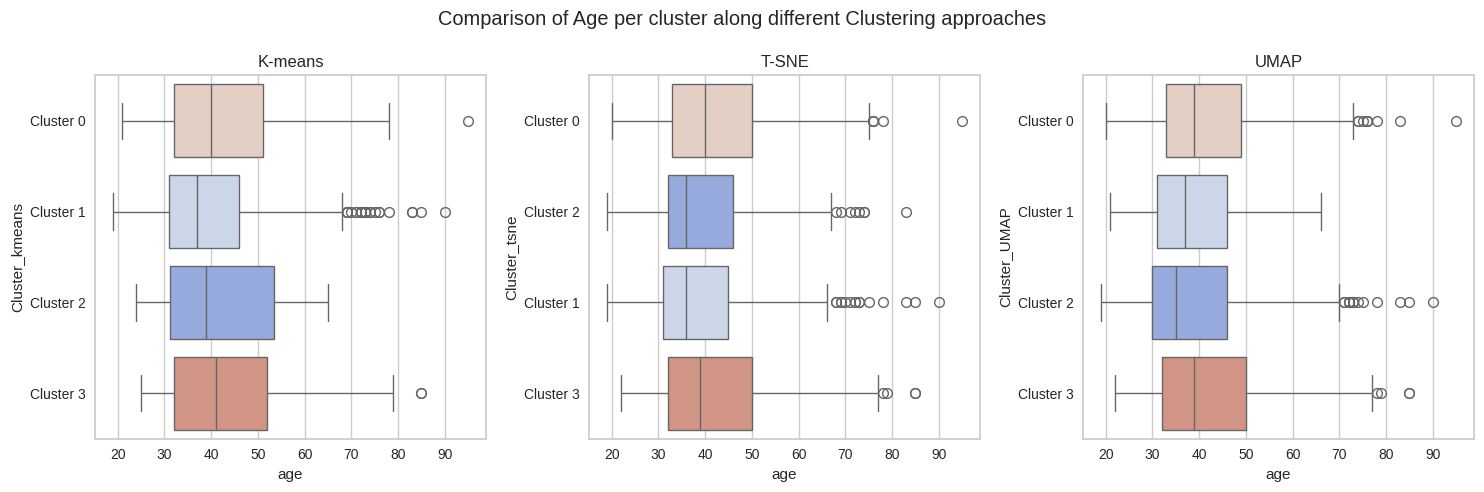

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

# Panel 1
sns.boxplot(data = df_subscribed_cluster3, x = 'age', y = 'Cluster_kmeans', palette = custom_palette, ax = axes[0])
axes[0].set_title('K-means')
# Panel 2
sns.boxplot(data = df_subscribed_cluster3, x = 'age', y = 'Cluster_tsne', palette = custom_palette, ax = axes[1])
axes[1].set_title('T-SNE')
# Panel 3
sns.boxplot(data = df_subscribed_cluster3, x = 'age', y = 'Cluster_UMAP', palette = custom_palette, ax = axes[2])
axes[2].set_title('UMAP')

fig.suptitle("Comparison of Age per cluster along different Clustering approaches")
plt.tight_layout()
plt.show()

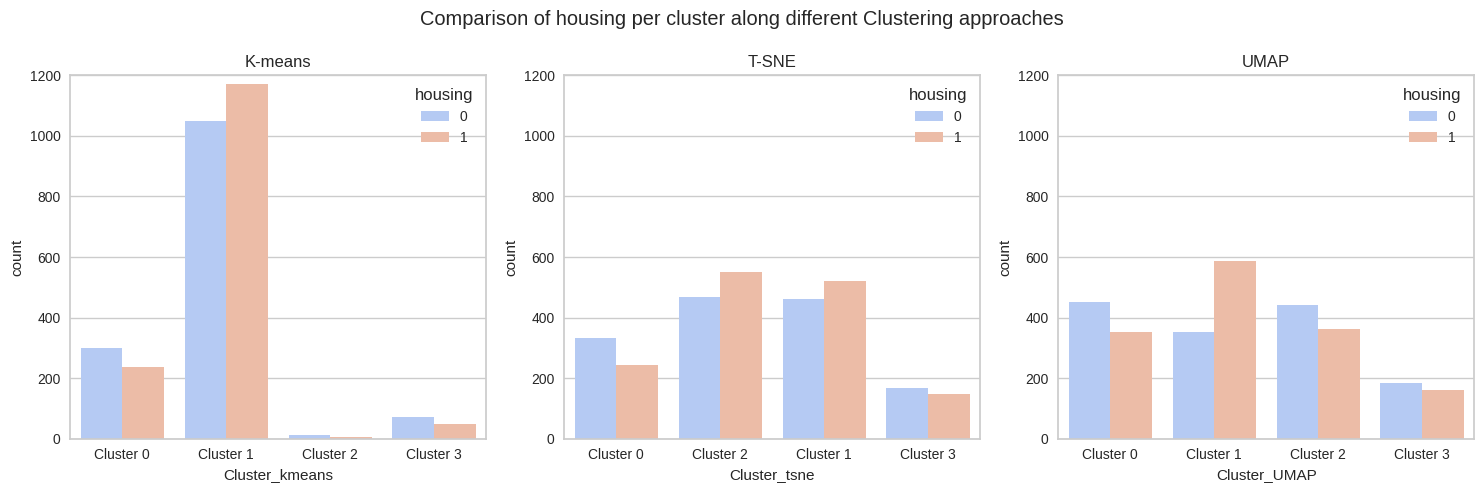

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

# Panel 1
sns.countplot(data = df_subscribed_cluster3, x = 'Cluster_kmeans', hue = 'housing', palette = 'coolwarm', ax = axes[0])
axes[0].set_title('K-means')
axes[0].set_ylim(0, 1200)

# Panel 2
sns.countplot(data = df_subscribed_cluster3, x = 'Cluster_tsne', hue = 'housing', palette = 'coolwarm', ax = axes[1])
axes[1].set_title('T-SNE')
axes[1].set_ylim(0, 1200)

# Panel 3
sns.countplot(data = df_subscribed_cluster3, x = 'Cluster_UMAP', hue = 'housing', palette = 'coolwarm', ax = axes[2])
axes[2].set_title('UMAP')
axes[2].set_ylim(0, 1200)

fig.suptitle("Comparison of housing per cluster along different Clustering approaches")
plt.tight_layout()
plt.show()

In [ ]:
list_1 = df_subscribed_cluster3['day'].unique()
list_1.sort()
list_1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

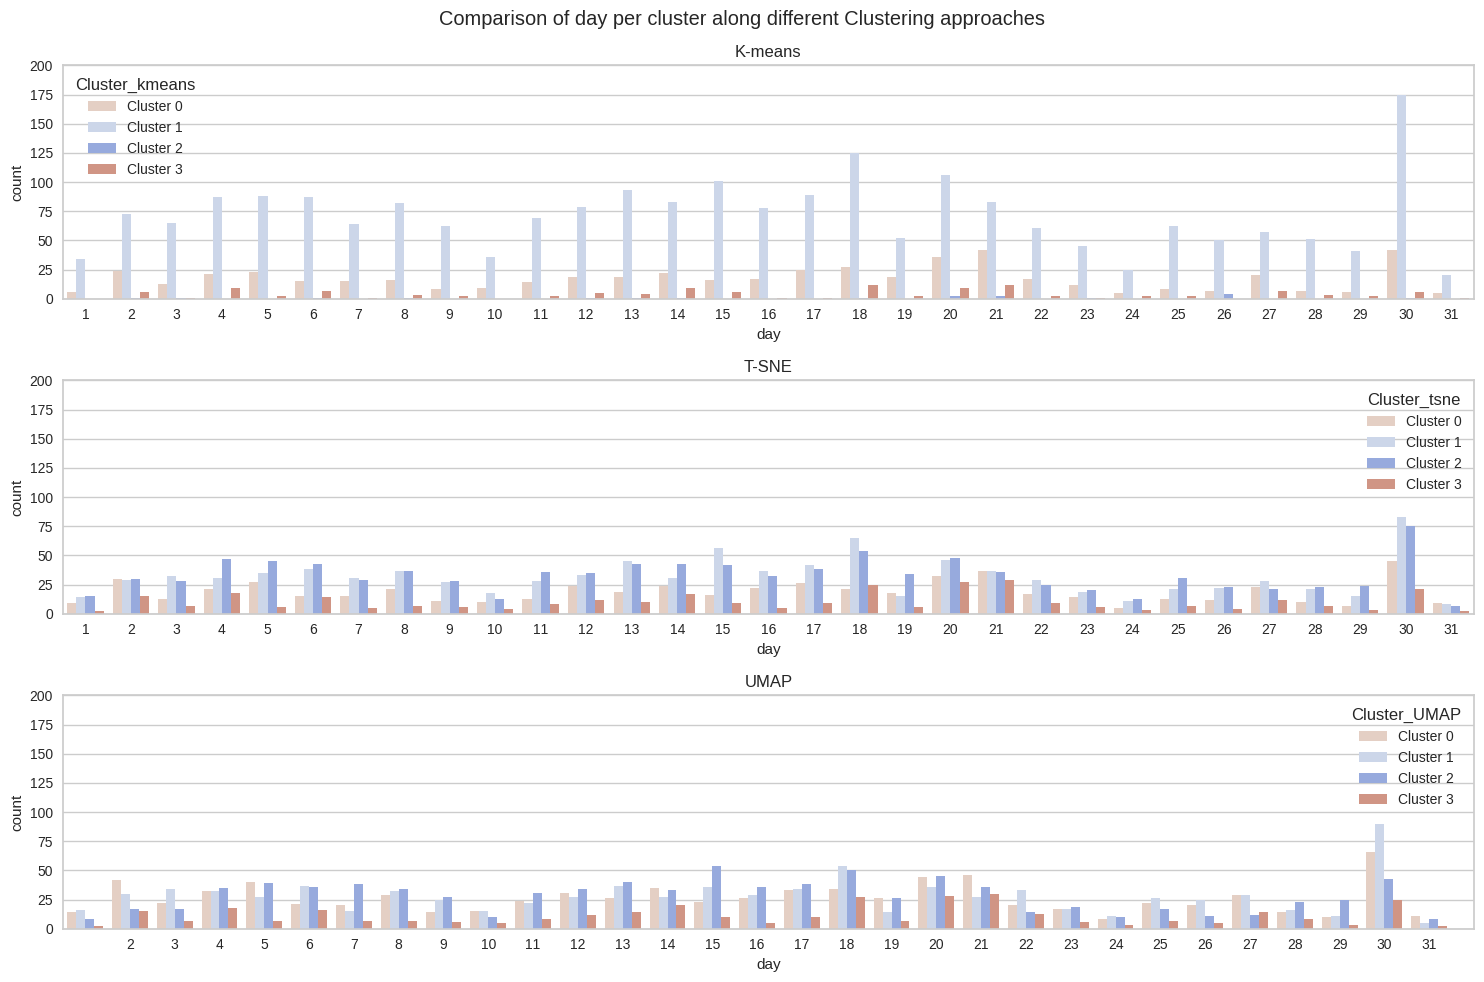

In [ ]:
fig, axes = plt.subplots(3, 1, figsize = (15, 10))

# Panel 1
sns.countplot(data = df_subscribed_cluster3, x = 'day', hue = 'Cluster_kmeans', palette = custom_palette, ax = axes[0],
              hue_order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[0].set_title('K-means')
axes[0].set_ylim(0, 200)
# Panel 2
sns.countplot(data = df_subscribed_cluster3, x = 'day', hue = 'Cluster_tsne', palette = custom_palette, ax = axes[1],
              hue_order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[1].set_title('T-SNE')
axes[1].set_ylim(0, 200)

# Panel 3
sns.countplot(data = df_subscribed_cluster3, x = 'day', hue = 'Cluster_UMAP', palette = custom_palette, ax = axes[2],
              hue_order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
axes[2].set_title('UMAP')
axes[2].set_ylim(0, 200)


fig.suptitle("Comparison of day per cluster along different Clustering approaches")
plt.tight_layout()
plt.xticks(list_1)
plt.show()

## **VI. Conclusions**

* **Supervised ML:**
  * The first layer is based on a tuned Decision Tree, achieving a recall of 0.83 on test dataset.
  * The first layer achieved to save a total of 960 hours of CSRs calls.
  * The second layer identified 2971 customers that must be contacted more that once since they are prone to subscribe. The achieved accuracy is ~0.94.

* **Clustering:**
  * Clusters built with *t-SNE* and *UMAP*, have a better construction than **stand-alone k-means.**
  * Cluster 3 (dark orange) is the most attractive segment of subscribers: it includes customers with high call duration and high balance. Generally the subscription is achieved in 2 or more calls.The range of age goes from ~24 to ~65, it seems that this cluster includes economically-active customers with high values in balance. Preferably, to maximize potential deposit amount, we will contact those cluster 2 customers that are single, with tertiary education, and with no previous loan history.

* **SHAP Analysis**
    * The most important positive contributor is the **duration of the call**: the longer the call, the more likely the customer will subscribe. Conversely, the less the call lasts, the lower the likeness of subscribing.
    * The output of the first layer of the ML model, **Layer1_Pred** is a positive contributor to the likeness of subscription. The predictions from the first layer of the ML model prove themselves helpful.
    * **Housing** is a negative contributor to subscription: customers are discouraged to subscribed as they have debt related to a property.

## **VII. Key Recommendations**

* **Short term:**

  * Focus efforts in performing follow up calls to Cluster 3 segment.
  * Perform special effort in day 30 of the month, for conversions seem to be doubled (specially clusters 1 and 2).
  * Apply campaign strategy focused on performing first contact calls to potential subscribers (first layer prediction).
  * Apply follow-up consistent strategy on high potential subscribers (second layer prediction).

* **Future work:**
  * Since longer calls are more likely to result in subscriptions, it is important to understand the content of this conversations:
    * What is the tone and emotion during the conversation between customers and CSRs?
    * What are the main topics discussed during the calls? Can we understand common issues?
    * Are there any unmet needs of the customer?

    * Tools as **Sentiment Analysis** and **Topic Analysis** are strongly recommended for mining on this questions. Relevant insights can be obtained to evaluate robustness of the product, and detect opportunities.









---



---

